# League of Legends Early Game Classification Analysis

* Student name: Johnny Dryman
* Student pace: full time
* Scheduled project review date/time: 5/27/2021
* Instructor name: James Irving

## Business Problem

League of Legends (LoL) is an intensely competitive game designed for 'core' gamers, or gamers who care deeply about winning the game.  Naturally, these players hate losing.  When I first started playing, I noticed that one of my teammates might "rage quit" a game within the first 10-20 minutes, leaving my teammates and I to an inevitable failure.  This made my experience suffer, and I could see my teammates lamenting in the chat as well.  Considering a single game of LoL can last for 45 minutes, the remaining 35 minutes was not an enjoyable experience.

When I discovered the dataset for League of Legends matches with only the first 10 minutes of data, I was inspired to try and find out whether or not my angry teammates were justified in rage quitting.  Was too much of the 45 minute game decided within the first 10 minutes?  Can I use machine learning to predict the winner with only 10 minutes of data?  What factors in the early game were most likely to lead to a victory?

The goal of this project is to take a look at how well a winner can be predicted based on early game information, and it also seeks to understand what specific factors can predict a victory.

# Data Import and Processing

Importing packages for importing data and exploratory visual analysis.

In [33]:
#Standard python libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 

# Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
scaler = StandardScaler()
from sklearn import metrics

# Models & Utilities
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings(action='ignore') 

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

This data was found on Kaggle: https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

In [34]:
# Importing data
df = pd.read_csv('data/high_diamond_ranked_10min.csv')

df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [35]:
# Taking a look at our columns
print(df.info())

# Checking for NA data
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

Fortunately there are no null values in our dataset.

There are a few columns that can be removed entirely and a few that can be combined into categorical variables.

### First Blood

'First Blood' is awarded to the team who gets the first kill in the game.  Both blueFirstBlood and redFirstBlood are binary and inversely related.  If Blue wins First Blood, blueFirstBlood will be recorded as 1 and redFirstBlood will be recorded as 0.  

We can merge these columns into one.

In [36]:
df['blueFirstBlood']

0       1
1       0
2       0
3       0
4       0
       ..
9874    1
9875    0
9876    0
9877    1
9878    1
Name: blueFirstBlood, Length: 9879, dtype: int64

In [37]:
firstBlood = []

for item in df['blueFirstBlood']:
    if item == 1:
        firstBlood.append('Blue')
    else:
        firstBlood.append('Red')
        
df['firstBlood'] = firstBlood

df['firstBlood']

0       Blue
1        Red
2        Red
3        Red
4        Red
        ... 
9874    Blue
9875     Red
9876     Red
9877    Blue
9878    Blue
Name: firstBlood, Length: 9879, dtype: object

We can discard blueFirstBlood and redFirstBlood

In [38]:
df = df.drop(['blueFirstBlood','redFirstBlood'], axis=1)

### Kills & Deaths

blueKills is inversely related with redDeaths, and redKills is inversely related with blueDeaths since the Blue team can only kill Red players and vice versa.  blueDeaths and redDeaths can both be removed, leaving kills intact will preserve this information.

In [39]:
df = df.drop(['blueDeaths','redDeaths'], axis=1)

### Dragon & Herald

While this wouldn't hold true for LoL data spanning the entire length of each game, we know that there is only one opportunity to kill both the Dragon and the Harold in the first 10 minutes of each match.  Unlike firstBlood where the action always occurs in the first 10 minutes (at least for the matches in our dataset), each dragon or herald can be killed only once or not at all.

Therefore, dragon and herald can be categorized as 'Blue,' 'Red,' or 'None.'

In [40]:
dragon_list = []

dragon_kill = df['blueDragons'] - df['redDragons']

for item in dragon_kill:
    if item == 1:
        dragon_list.append('Blue')
    elif item == -1:
        dragon_list.append('Red')
    else:
        dragon_list.append('No Dragon')
        
df['dragon'] = dragon_list

blueDragons and redDragons can be removed:

In [41]:
df = df.drop(['blueDragons','redDragons'], axis=1)

We can reuse this code for the herald feature:

In [42]:
herald_list = []

herald_kill = df['blueHeralds'] - df['redHeralds']

for item in herald_kill:
    if item == 1:
        herald_list.append('Blue')
    elif item == -1:
        herald_list.append('Red')
    else:
        herald_list.append('No Herald')
        
df['herald'] = herald_list

In [43]:
df = df.drop(['blueHeralds','redHeralds'], axis=1)

### Elite Monsters

In the first 10 minutes of a match, Elite Monsters will receive +1 if a team kills the Dragon and another +1 if the same team kills the Herald.  It is redundant information from what we already have with the Dragon and Harold features.  

In [44]:
df = df.drop(['blueEliteMonsters','redEliteMonsters'], axis=1)

### GoldDiff, ExperienceDiff, CSPerMin, and GoldPerMin

Both blue and red teams have these four metrics.  While they are useful metrics for other types of analyses, they are essentially duplicative, since they are all calculated in a similar fashion from features already included in our data.  

- GoldDiff represents the difference between blueTotalGold and redTotalGold
- ExperienceDiff represents the difference between blueTotalExperience and redTotalExperience
- blue and red CSPerMin represents the minute rate of blue and red TotalMinionsKilled.  For our 10 minute data, CSPerMin for each team will always be TotalMinionsKilled divided by 10
- similarly, blue and red GoldPerMin represents blue and red TotalGold divided by 10

These four features from both teams (totaling 8 features) can be removed without losing any information.


In [45]:
df = df.drop(['blueGoldDiff',
            'blueExperienceDiff',
            'blueCSPerMin',
            'blueGoldPerMin',
            'redGoldDiff',
            'redExperienceDiff',
            'redCSPerMin',
            'redGoldPerMin'], axis=1)

### gameId

gameId represents a unique identifier for every LoL game, no two gameId's will ever be the same, so this column can be removed.

In [46]:
df = df.drop(['gameId'], axis=1)

### Merging Continuous Features

For this analysis, we will combine all blue and red continuous features into single features that will represent that +/- ratio of blue compared to red.  If a continuous value is positive, that means blue had that much more than red.  If a feature is negative, the absolute value of that negative number represents red's greater value.  

In [47]:
# Saving copy of dataframe so far before merging continuous features
df_blue_red = df.copy()

# Instantiating empty dataframe
diff_df = pd.DataFrame()

# Building diff_df by calculating differences between blue and red stats
diff_df['WardsPlaced'] = df['blueWardsPlaced'] - df['redWardsPlaced']
diff_df['WardsDestroyed'] = df['blueWardsDestroyed'] - df['redWardsDestroyed']
diff_df['Kills'] = df['blueKills'] - df['redKills']
diff_df['Assists'] = df['blueAssists'] - df['redAssists']
diff_df['TowersDestroyed'] = df['blueTowersDestroyed'] - df['redTowersDestroyed']
diff_df['TotalGold'] = df['blueTotalGold'] - df['redTotalGold']
diff_df['AvgLevel'] = df['blueAvgLevel'] - df['redAvgLevel']
diff_df['TotalExperience'] = df['blueTotalExperience'] - df['redTotalExperience']
diff_df['TotalMinionsKilled'] = df['blueTotalMinionsKilled'] - df['redTotalMinionsKilled']
diff_df['TotalJungleMinionsKilled'] = df['blueTotalJungleMinionsKilled'] - df['redTotalJungleMinionsKilled']

# Merging with categorical features
diff_df = pd.concat([diff_df, df[['firstBlood', 'dragon', 'herald', 'blueWins']]], axis=1)

df = diff_df

df.head()

,WardsPlaced,WardsDestroyed,Kills,Assists,TowersDestroyed,TotalGold,AvgLevel,TotalExperience,TotalMinionsKilled,TotalJungleMinionsKilled,firstBlood,dragon,herald,blueWins
0,13,-4,3,3,0,643,-0.2,-8,-2,-19,Blue,No Dragon,No Herald,0
1,0,0,0,3,-1,-2908,-0.2,-1173,-66,-9,Red,Red,Red,0
2,0,-3,-4,-10,0,-1172,-0.4,-1033,-17,18,Red,Blue,No Herald,0
3,28,-1,-1,-5,0,-1321,0.0,-7,-34,8,Red,No Dragon,Blue,0
4,58,2,0,-1,0,-1004,0.0,230,-15,-10,Red,Red,No Herald,0


# Exploratory Analysis

## Visualizations

<AxesSubplot:xlabel='blueWins', ylabel='Count'>

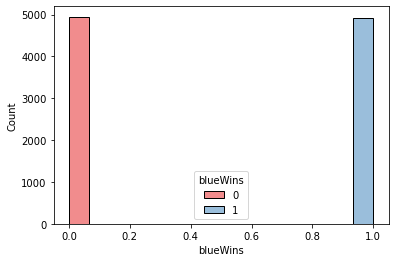

In [49]:
sns.histplot(x='blueWins', data=df, hue='blueWins', palette='Set1', kde=True)

The win split seems pretty even, so it seems there is no overt advantage to being either blue or red.

<AxesSubplot:xlabel='Kills', ylabel='Count'>

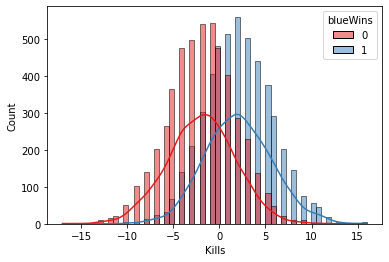

In [50]:
sns.histplot(x='Kills', data=df, hue='blueWins', palette='Set1', kde=True)

It seems clear that outperforming in kills has an influence on winning.

<AxesSubplot:xlabel='Assists', ylabel='Count'>

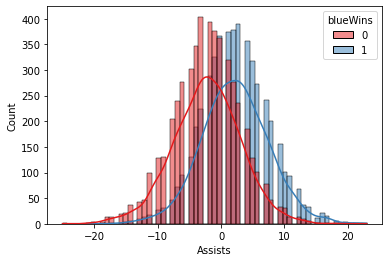

In [51]:
sns.histplot(x='Assists', data=df, hue='blueWins', palette='Set1', kde=True)

Assists still seem relevant and are also somewhat incidental to kills, but the disparity with assists is less clear.

<AxesSubplot:xlabel='dragon', ylabel='count'>

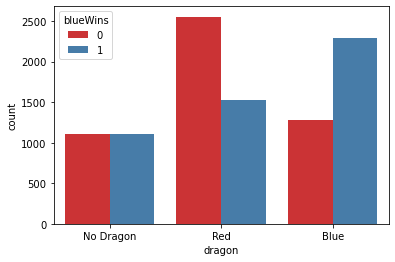

In [52]:
sns.countplot(x='dragon', data=df, hue='blueWins', palette='Set1')


Killing the dragon in the first 10 minutes seems to have a positive influence on winning.  While it might be telling of a win, there are plenty of instances where blue kills the dragon, but red kills the game.  

It's interesting that in the event of no dragon being killed, the victory split for blue and red are nearly identical.

<AxesSubplot:xlabel='herald', ylabel='count'>

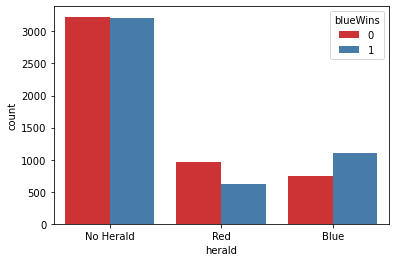

In [53]:
sns.countplot(x='herald', data=df, hue='blueWins', palette='Set1')


There's still an impact for killing the Herald, but it isnt' nearly as significant.  It's also not incredibly common within the first 10 minutes.

<AxesSubplot:xlabel='firstBlood', ylabel='count'>

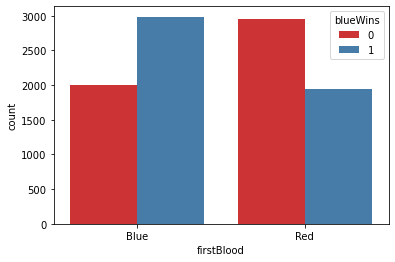

In [54]:
sns.countplot(x='firstBlood', data=df, hue='blueWins', palette='Set1')


First blood is also a notable influencer on victory, but it isn't quite as strong as killing the dragon

<AxesSubplot:xlabel='TotalGold', ylabel='Count'>

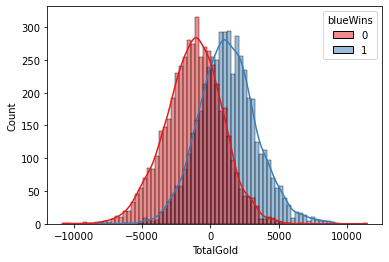

In [55]:
sns.histplot(x='TotalGold', data=df, hue='blueWins', palette='Set1', kde=True)

Gold is also an indicator of victory.  Based on just the graph, it doesn't appear to influnce victory more than kills or assists.

<AxesSubplot:xlabel='WardsPlaced', ylabel='Count'>

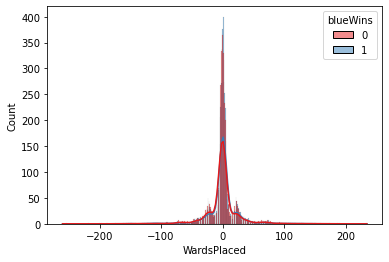

In [99]:
sns.histplot(x='WardsPlaced', data=df, hue='blueWins', palette='Set1', kde=True)

The spread on Wards doesn't seem too telling of a victory.  There's also a significant amount of outliers.

## Multicollinearity

(<Figure size 1080x720 with 2 Axes>, <AxesSubplot:>)

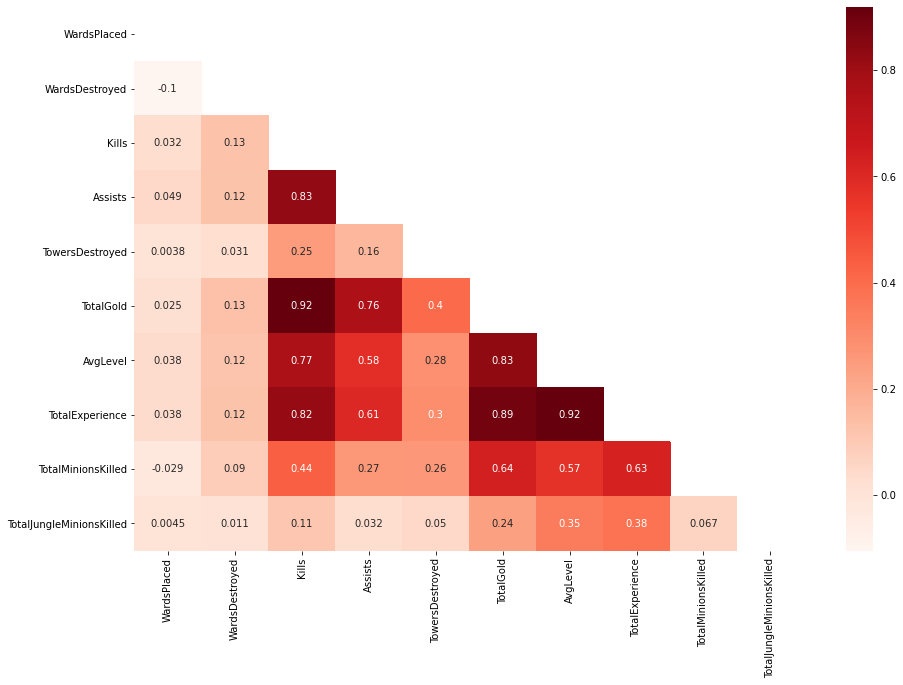

In [101]:
def heatmap(df_name, figsize=(15,10), cmap='Reds'):
    corr = df_name.drop('blueWins',axis=1).corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask)
    return fig, ax

heatmap(df)

In [58]:
# https://pydatascience.org/2019/07/23/remove-duplicates-from-correlation-matrix-python/
def corr_list(df):
    dataCorr = df.drop('blueWins',axis=1).corr()

    dataCorr = dataCorr[abs(dataCorr) >= 0.01].stack().reset_index()
    dataCorr = dataCorr[dataCorr['level_0'].astype(str)!=dataCorr['level_1'].astype(str)]

    # filtering out lower/upper triangular duplicates 
    dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
    dataCorr = dataCorr.drop_duplicates(['ordered-cols'])
    dataCorr.drop(['ordered-cols'], axis=1, inplace=True)

    return dataCorr.sort_values(by=[0], ascending=False).head(10) #Get 10 highest correlation of pairwaise attributes

corr_list(df)


,level_0,level_1,0
64,AvgLevel,TotalExperience,0.919161
23,Kills,TotalGold,0.917008
54,TotalGold,TotalExperience,0.894729
53,TotalGold,AvgLevel,0.833493
21,Kills,Assists,0.830751
25,Kills,TotalExperience,0.822845
24,Kills,AvgLevel,0.766222
33,Assists,TotalGold,0.759321
55,TotalGold,TotalMinionsKilled,0.638765
75,TotalExperience,TotalMinionsKilled,0.625556


Our multicollinearity analysis has presented a few variable relationships that need additional consideration.

- avgLevel and TotalExperience are highly correlated, which is not surprising.  For now, we will stick with TotalExperience since it's a bit more precise than AvgLevel.  
- TotalGold appears consistently in our list.  This is also not surprising since kills and assists award gold.  We will experiment with removing TotalGold for feature analysis.

In [59]:
corr_list(diff_df)

,level_0,level_1,0
64,AvgLevel,TotalExperience,0.919161
23,Kills,TotalGold,0.917008
54,TotalGold,TotalExperience,0.894729
53,TotalGold,AvgLevel,0.833493
21,Kills,Assists,0.830751
25,Kills,TotalExperience,0.822845
24,Kills,AvgLevel,0.766222
33,Assists,TotalGold,0.759321
55,TotalGold,TotalMinionsKilled,0.638765
75,TotalExperience,TotalMinionsKilled,0.625556


# MODEL

## Train Test Split

In [60]:
# Isolate target and features

y = df['blueWins']
X = df.drop(columns=['blueWins'], axis=1)

# Create train / test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Confirm split

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6915, 13)
X_test shape: (2964, 13)


### Categorical Columns

In [61]:
# Separate feautures into continuous and categorical

categoricals = X.select_dtypes('O').columns
numericals = X.select_dtypes('number').columns
categoricals, numericals

(Index(['firstBlood', 'dragon', 'herald'], dtype='object'),
 Index(['WardsPlaced', 'WardsDestroyed', 'Kills', 'Assists', 'TowersDestroyed',
        'TotalGold', 'AvgLevel', 'TotalExperience', 'TotalMinionsKilled',
        'TotalJungleMinionsKilled'],
       dtype='object'))

In [62]:
# Encode categorical columns, only drop if binary

encoder = OneHotEncoder(sparse=False,drop='if_binary')
train_categoricals = encoder.fit_transform(X_train[categoricals])
test_categoricals = encoder.transform(X_test[categoricals])
train_categoricals

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [63]:
# Convert train and test categoricals into dataframes for merge

train_categoricals_df = pd.DataFrame(train_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

test_categoricals_df =  pd.DataFrame(test_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

train_categoricals_df.head()

,firstBlood_Red,dragon_Blue,dragon_No Dragon,dragon_Red,herald_Blue,herald_No Herald,herald_Red
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0


### Numerical Columns

In [64]:
# Scale continuous features and combine into dataframe for merge

scaler = scaler = StandardScaler()

train_numericals_df = pd.DataFrame(scaler.fit_transform(X_train[numericals]),
                              columns=numericals)

test_numericals_df = pd.DataFrame(scaler.transform(X_test[numericals]),
                              columns=numericals)

train_numericals_df.head()

,WardsPlaced,WardsDestroyed,Kills,Assists,TowersDestroyed,TotalGold,AvgLevel,TotalExperience,TotalMinionsKilled,TotalJungleMinionsKilled
0,-0.312890,1.373334,0.220704,-0.349942,-0.04164,-0.001092,-0.821423,-0.486820,-1.461816,1.449220
1,0.156072,-0.741644,0.220704,-0.003060,-0.04164,-0.440888,-0.821423,-0.545091,-0.784545,-1.143374
2,-0.000249,-0.389148,-0.733301,-0.349942,-0.04164,-0.276167,-0.405661,-0.490982,-0.816796,2.079851
3,0.156072,1.373334,2.128716,2.425111,-0.04164,2.063192,1.673149,1.640596,1.344019,-1.073304
4,-0.039329,-0.036651,0.697707,0.343822,-0.04164,0.381093,0.010101,0.397652,0.795753,-1.143374


In [65]:
# Recombine transformed categorical and continuous features, print shape

X_train = pd.concat([train_numericals_df, train_categoricals_df], axis=1)
X_test = pd.concat([test_numericals_df, test_categoricals_df], axis=1)

print(X_train.shape)
print(X_test.shape)

(6915, 17)
(2964, 17)


## Logistic Regression

In [66]:
# Initiate and train model

model_log = LogisticRegression()

model_log.fit(X_train, y_train)

LogisticRegression()

In [67]:
# Test for class imbalance

print(y_train.value_counts(1))
print(y_test.value_counts(1))

1    0.500217
0    0.499783
Name: blueWins, dtype: float64

### Accuracy

In [70]:
# Create function for efficient accuracy checks

def model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')

model_accuracy(model_log)

Training Accuracy: 74.04%
Test Accuracy: 71.69%


### Cross Validation Check

In [71]:
# Create cross validation function 

def cross_val_check(model_string_name, model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    scores = cross_val_score(model, X_train, y_train, cv=10) # model, train, target, cross validation
    print(f'{model_string_name} Cross Validation Scores:\n')
    print(scores)
    print(f'\nCross validation mean: \t{scores.mean():.2%}')
    
cross_val_check('Logistic Regression', model_log)

Logistic Regression Cross Validation Scores:

[0.72976879 0.73265896 0.75867052 0.73410405 0.73988439 0.74384949
 0.72503618 0.75253256 0.72648336 0.73950796]

Cross validation mean: 	73.82%


### Confusion Matrix & Classification Report

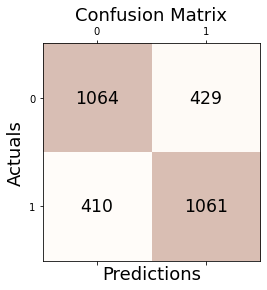

In [72]:
# # https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

y_pred = model_log.predict(X_test)
#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [73]:
## Modified version of our simple eval function from Topic 25 Part 2 Study Group
# - Added X_train and y_train for if we want scores for both train and test
def evaluate_classification(model, X_test_tf,y_test,cmap='Blues',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):

    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
    curve.ax_.grid()
    curve.ax_.plot([0,1],[0,1],ls=':')
    fig.tight_layout()
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
        
        
def evaluate_grid(grid,X_test,y_test,X_train=None,y_train=None):
    print('The best parameters were:')
    print("\t",grid.best_params_)
    
    model = grid.best_estimator_    

    print('\n[i] Classification Report')
    evaluate_classification(model, X_test,y_test,X_train=X_train,y_train=y_train)

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1493
           1       0.71      0.72      0.72      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



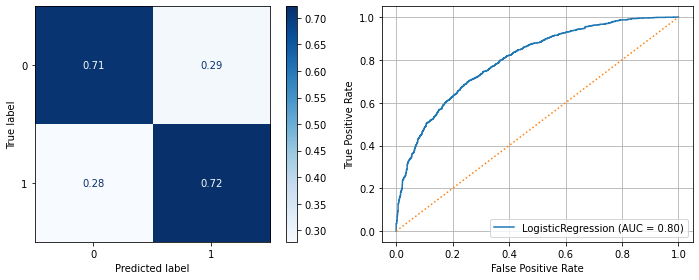

In [74]:
evaluate_classification(model_log, X_test, y_test)

### Dummy Check

0.4848178137651822
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1493
           1       0.49      0.50      0.49      1471

    accuracy                           0.50      2964
   macro avg       0.50      0.50      0.50      2964
weighted avg       0.50      0.50      0.50      2964



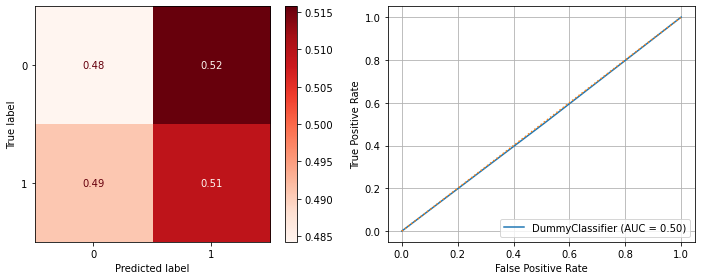

In [75]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='stratified')#,constant=0)

preds = dummy.fit(X_train,y_train).predict(X_test)

## How did we do?
print(dummy.score(X_test,y_test))

evaluate_classification(dummy,X_test, y_test, cmap='Reds')#,label='Dummy');

### Hypertuning Logistic Regression

In [76]:
# Initiate new model and perform grid search

model_log_hp = LogisticRegression()

params = {'C':[0.001,0.01,0.1,1,10,100,1000],
        'penalty':['l1','l2','elastic_net'],
        'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"]
         }

log_grid_search = GridSearchCV(model_log_hp,params,scoring='accuracy')

In [77]:
# Fit grid search to training data and display best parameters

log_grid_search.fit(X_train, y_train)

log_grid_search.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [78]:
# Compare performance between base model and grid search model

print("Base Model:")
model_accuracy(model_log)
print("\n")
print("Grid Search Model:")
model_accuracy(log_grid_search)

Base Model:
Training Accuracy: 74.04%
Test Accuracy: 71.69%


Grid Search Model:
Training Accuracy: 74.09%
Test Accuracy: 71.83%


              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1493
           1       0.71      0.72      0.72      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



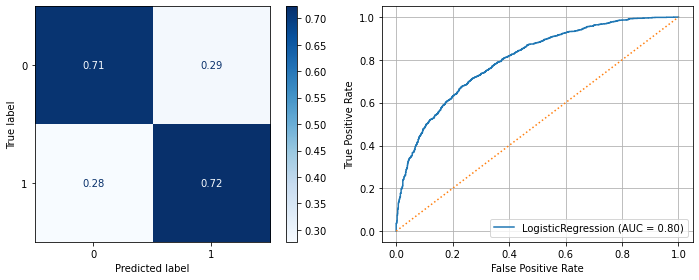

In [79]:
# Evaluate best model found with grid search

evaluate_classification(log_grid_search.best_estimator_,X_test,y_test)

### Coefficients

In [ ]:
# Create coefficient graph function

def coef_graph(X_train, X_test, y_train=y_train, y_test=y_test):    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns).sort_values(ascending=True)
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    ax = coeffs.plot(kind='barh', figsize=(8,6))
    

Let's first take a look at feature importances using all of our features.

Training Accuracy: 74.04%
Test Accuracy: 71.69%


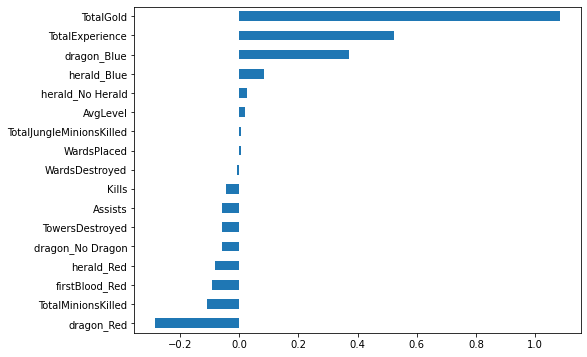

In [80]:
coef_graph(X_train, X_test)

TotalGold is clearly the most predictive feature for victory.  

Earlier, we noticed TotalGold has very high multicollinearity with multiple features.  This isn't surprising, since gold is a resource won from actions taken in the game.  Killing opponents, elite monsters, and creeps all award gold.  

Training Accuracy: 73.25%
Test Accuracy: 71.29%


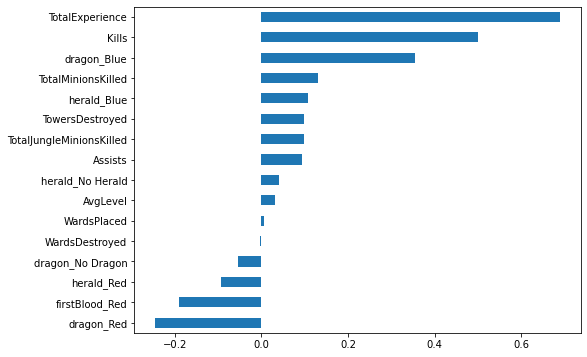

In [81]:
X_train_coeff = X_train.drop(['TotalGold'],axis=1)
X_test_coeff = X_test.drop(['TotalGold'],axis=1)

coef_graph(X_train_coeff, X_test_coeff)

Training Accuracy: 73.03%
Test Accuracy: 70.75%


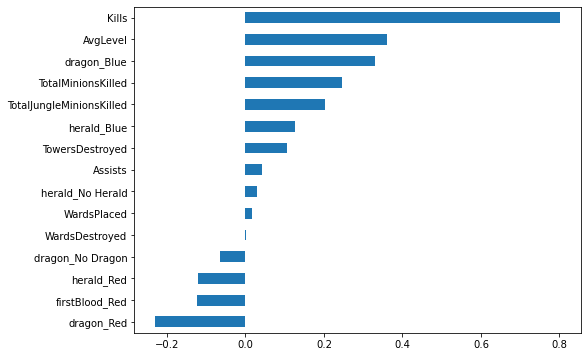

In [82]:
X_train_coeff = X_train.drop(['TotalGold', 'TotalExperience'],axis=1)
X_test_coeff = X_test.drop(['TotalGold', 'TotalExperience'],axis=1)

coef_graph(X_train_coeff, X_test_coeff)

Training Accuracy: 73.04%
Test Accuracy: 70.48%


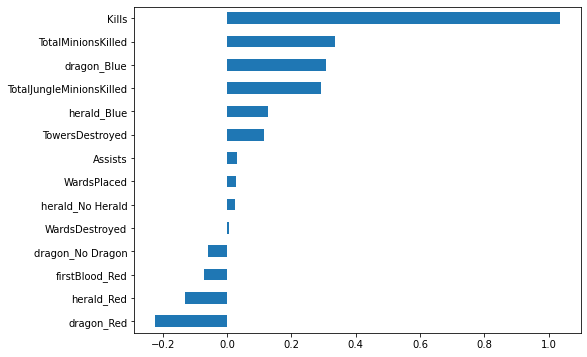

In [83]:
X_train_coeff = X_train.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)
X_test_coeff = X_test.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)

coef_graph(X_train_coeff, X_test_coeff)

Training Accuracy: 71.27%
Test Accuracy: 69.84%


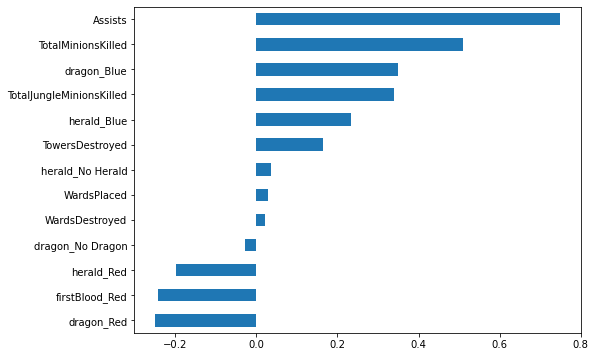

In [84]:
X_train_coeff_nokills = X_train.drop(['TotalGold', 'TotalExperience', 'AvgLevel', 'Kills'],axis=1)
X_test_coeff_nokills = X_test.drop(['TotalGold', 'TotalExperience', 'AvgLevel', 'Kills'],axis=1)

coef_graph(X_train_coeff_nokills, X_test_coeff_nokills)

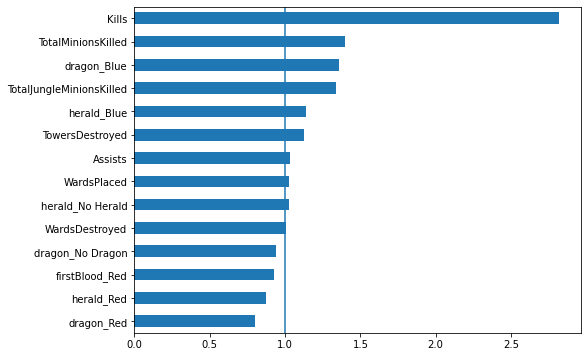

In [85]:
model = LogisticRegression()

model.fit(X_train_coeff, y_train)

coef = pd.Series(model.coef_.flatten(), index=X_train_coeff.columns).sort_values(ascending=True)

odds = np.exp(coef)
ax = odds.plot(kind='barh', figsize=(8,6))
ax.axvline(1)


For every 1 sd increase in Kills, the odds that blue wins is are 3.0 x as large as the odds that they lost

## Random Forest

In [86]:
# Initiate a random forest model
model_rf = RandomForestClassifier(random_state=8)
model_rf.fit(X_train, y_train)

# Check accuracy
model_accuracy(model_rf)

Training Accuracy: 99.99%
Test Accuracy: 70.85%


In [87]:
# # Training accuracy score
# model_rf.score(X_train, y_train)

In [88]:
cross_val_check('Random Forest', model_rf)

Random Forest Cross Validation Scores:

[0.69508671 0.71387283 0.75867052 0.72543353 0.73699422 0.73516643
 0.71635311 0.73082489 0.71490593 0.70622287]

Cross validation mean: 	72.34%


              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1493
           1       0.71      0.72      0.72      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



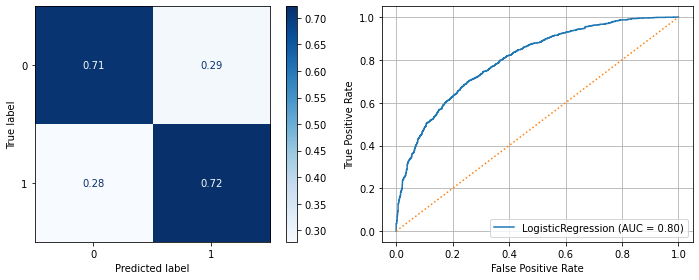

In [89]:
evaluate_classification(model_log, X_test, y_test)

RF tends to shift away from our categoricals.

### RF Hyperparameter

In [90]:
run = False

# Initiate new random forest model
model_rf_hp = RandomForestClassifier()

# Define grid search parameters

if run == True:
    rf_param_grid = {
        'n_estimators': [10, 30, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 6, 10],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [3, 6]}
else:
    rf_param_grid = {
        'n_estimators': [30],
        'criterion': ['entropy'],
        'max_depth': [6],
        'min_samples_split': [5],
        'min_samples_leaf': [6]}

# Run grid search and fit to train data
rf_grid_search = GridSearchCV(model_rf_hp, rf_param_grid, cv=2)
rf_grid_search.fit(X_train, y_train)

# Print metrics
print("---Random Forest Base Model---")
model_accuracy(model_rf)
print("")
print("---Grid Search Model---")
model_accuracy(rf_grid_search)
print("")
print(f"Cross Validated Score: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

---Random Forest Base Model---
Training Accuracy: 99.99%
Test Accuracy: 70.85%

---Grid Search Model---
Training Accuracy: 74.77%
Test Accuracy: 71.36%

Cross Validated Score: 73.43%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 30}


In [91]:
# Print metrics

print("---Random Forest Base Model---")
model_accuracy(model_rf)
print("")
print("---Grid Search Model---")
model_accuracy(rf_grid_search)
print("")
print(f"Cross Validated Score: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

---Random Forest Base Model---
Training Accuracy: 99.99%
Test Accuracy: 70.85%

---Grid Search Model---
Training Accuracy: 74.77%
Test Accuracy: 71.36%

Cross Validated Score: 73.43%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 30}


In [92]:
rf_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 6,
 'min_samples_split': 5,
 'n_estimators': 30}

In [93]:
model = RandomForestClassifier(**rf_grid_search.best_params_)

model.fit(X_train, y_train)

model_accuracy(model)

Training Accuracy: 75.07%
Test Accuracy: 71.66%


              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1493
           1       0.71      0.70      0.71      1471

    accuracy                           0.71      2964
   macro avg       0.71      0.71      0.71      2964
weighted avg       0.71      0.71      0.71      2964



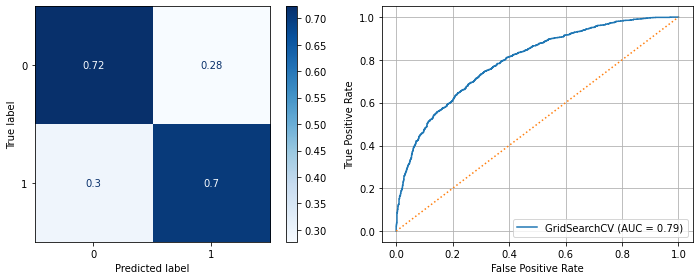

In [94]:
evaluate_classification(rf_grid_search, X_test, y_test)

### Feature Importances

Training Accuracy: 75.39%
Test Accuracy: 71.83%


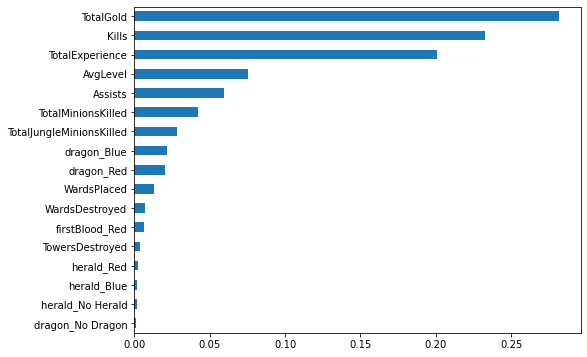

In [95]:
def feature_graph(model, X_train, X_test, y_train=y_train, y_test=y_test):    
    model = model
    model.fit(X_train, y_train)
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    ax = feature_importance.plot(kind='barh', figsize=(8,6))

rf_model = RandomForestClassifier(**rf_grid_search.best_params_)
    
feature_graph(rf_model, X_train, X_test)


Training Accuracy: 74.19%
Test Accuracy: 69.94%


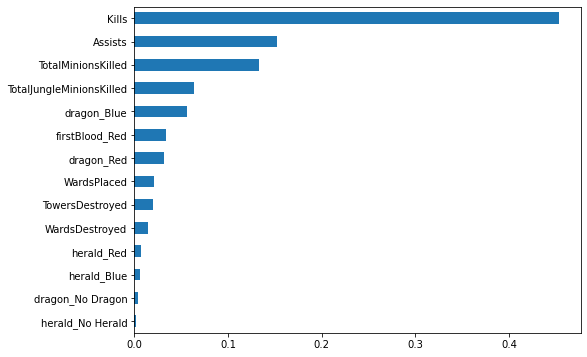

In [96]:
X_train_coeff = X_train.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)
X_test_coeff = X_test.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)

feature_graph(rf_model, X_train_coeff, X_test_coeff)

## XGBoost

In [97]:
# Initiate and train XGB model
model_xgb = XGBClassifier()
model_xgb.fit(X_train_br, y_train)

model_accuracy(model_xgb)

ValueError: feature_names mismatch: ['blueWardsPlaced', 'blueWardsDestroyed', 'blueKills', 'blueAssists', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed', 'redKills', 'redAssists', 'redTowersDestroyed', 'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'firstBlood_Red', 'dragon_Blue', 'dragon_No Dragon', 'dragon_Red', 'herald_Blue', 'herald_No Herald', 'herald_Red'] ['WardsPlaced', 'WardsDestroyed', 'Kills', 'Assists', 'TowersDestroyed', 'TotalGold', 'AvgLevel', 'TotalExperience', 'TotalMinionsKilled', 'TotalJungleMinionsKilled', 'firstBlood_Red', 'dragon_Blue', 'dragon_No Dragon', 'dragon_Red', 'herald_Blue', 'herald_No Herald', 'herald_Red']
expected blueTotalJungleMinionsKilled, blueWardsPlaced, blueWardsDestroyed, blueTotalExperience, redWardsDestroyed, redTotalJungleMinionsKilled, redTotalGold, blueAssists, blueTotalGold, blueAvgLevel, redTowersDestroyed, blueTowersDestroyed, redWardsPlaced, blueTotalMinionsKilled, redKills, blueKills, redAssists, redTotalExperience, redAvgLevel, redTotalMinionsKilled in input data
training data did not have the following fields: WardsDestroyed, Assists, TotalJungleMinionsKilled, AvgLevel, TotalMinionsKilled, TotalExperience, Kills, WardsPlaced, TotalGold, TowersDestroyed

In [ ]:
cross_val_check('XGBoost', model_xgb)

In [ ]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 100, 1000]}


In [ ]:
run = False

if run == True:

    model_xgb_hp = XGBClassifier()

    xgb_grid_search = GridSearchCV(model_xgb_hp, param_grid, scoring='accuracy', cv=None, n_jobs=-1, verbose=100)
    xgb_grid_search.fit(X_train, y_train)

    model_accuracy(xgb_grid_search)
    
    xgb_best_parameters = xgb_grid_search.best_params_

    print(f"Cross Validated Score: {xgb_grid_search.best_score_ :.2%}")
    print("")
    print(f"Optimal Parameters: {xgb_grid_search.best_params_}")
    
else:
    xgb_best_parameters = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.5,
    'n_estimators': 100
    }

    model_xgb_hp = XGBClassifier(**xgb_best_parameters)
    model_xgb_hp.fit(X_train, y_train)
    model_accuracy(model_xgb_hp)

In [ ]:
evaluate_classification(model_xgb_hp, X_test, y_test)

In [ ]:
feature_graph(model_xgb_hp, X_train, X_test)

In [ ]:
X_train_feat_xgb = X_train.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)
X_test_feat_xgb = X_test.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)

feature_graph(model_xgb_hp, X_train_feat_xgb, X_test_feat_xgb)

# iNTERPRET

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

In [ ]:

# Create function used to find Precision, Recall, Accuracy, and F1 Scores.
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    

            
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

# Create a function that visualizes the confusion matrix for the model.    
def plot_cm(model, normalize='true'):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.grid(False)
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', ax=ax, normalize=normalize)


In [27]:
def tt_split_df(df):
    
    y = df['blueWins']
    X = df.drop(columns=['blueWins'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    X_train_tf = X_train.copy()
    X_test_tf = X_test.copy()
    
    categoricals = X.select_dtypes('O').columns
    numericals = X.select_dtypes('number').columns
    
    encoder = OneHotEncoder(sparse=False,drop='if_binary')
    train_categoricals = encoder.fit_transform(X_train_tf[categoricals])
    test_categoricals = encoder.transform(X_test_tf[categoricals])
    
    train_categoricals_df = pd.DataFrame(train_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

    test_categoricals_df =  pd.DataFrame(test_categoricals,
                                     columns=encoder.get_feature_names(categoricals))
    train_numericals_df = pd.DataFrame(scaler.fit_transform(X_train_tf[numericals]),
                              columns=numericals)

    test_numericals_df = pd.DataFrame(scaler.transform(X_test_tf[numericals]),
                              columns=numericals)
    
    X_train_tf = pd.concat([train_numericals_df, train_categoricals_df], axis=1)
    X_test_tf = pd.concat([test_numericals_df, test_categoricals_df], axis=1)
    
    return X_train_tf, X_test_tf, y_train, y_test

# tt_split_df(diff_df)

X_train, X_test, y_train, y_test = tt_split_df(df)

In [28]:
# Initiate and train model
def model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')

# model_accuracy(model_log)


model_log = LogisticRegression()

model_log.fit(X_train, y_train)

model_accuracy(model_log, X_train=X_train, X_test=X_test)

Training Accuracy: 73.28%
Test Accuracy: 73.28%


In [ ]:
X_train_br

In [ ]:
X_train_br, X_test_br, y_train, y_test = tt_split_df(df_blue_red)

mod = LogisticRegression()

mod.fit(X_train_br, y_train)

model_accuracy(mod, X_train=X_train_br, X_test=X_test_br)
# model_accuracy(mod)

In [29]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 100, 1000]}


In [32]:
run = True

if run == True:

    model_xgb_hp = XGBClassifier()

    xgb_grid_search = GridSearchCV(model_xgb_hp, param_grid, scoring='accuracy', cv=None, n_jobs=-1, verbose=100)
    xgb_grid_search.fit(X_train, y_train)

    model_accuracy(xgb_grid_search)
    
    xgb_best_parameters = xgb_grid_search.best_params_

    print(f"Cross Validated Score: {xgb_grid_search.best_score_ :.2%}")
    print("")
    print(f"Optimal Parameters: {xgb_grid_search.best_params_}")
    
else:
    xgb_best_parameters = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.5,
    'n_estimators': 100
    }

    model_xgb_hp = XGBClassifier(**xgb_best_parameters)
    model_xgb_hp.fit(X_train, y_train)
    model_accuracy(model_xgb_hp, X_train=X_train_br, X_test=X_test_br)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1170s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 

[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 191 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:   37.4s
[Paralle

[Parallel(n_jobs=-1)]: Done 311 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 313 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 315 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 319 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 321 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 323 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed:  1.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 447 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 451 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 453 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 455 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 459 tasks      | elapsed:  2.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 577 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 579 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 581 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 582 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 586 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 587 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 590 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 591 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:  2.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 710 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 711 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 712 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 715 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 717 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 719 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 721 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 722 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 723 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 725 tasks      | elapsed:  3.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 843 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 845 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 846 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 847 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 849 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 851 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 853 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 854 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 855 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 857 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  4.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 977 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 978 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 979 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 982 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 983 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 985 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 986 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 987 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 988 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 990 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 991 tasks      | elapsed:  5.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 1109 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1110 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1111 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1113 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1114 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1115 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1116 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1117 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1118 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1119 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1121 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1123 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1243 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1244 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1245 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1247 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1249 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1251 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1252 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1253 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1254 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1255 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1257 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1374 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1375 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1377 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1378 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1379 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1380 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1381 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1383 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1384 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1385 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1386 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1387 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed: 

In [31]:
model_accuracy(xgb_grid_search)

Training Accuracy: 49.73%
Test Accuracy: 48.99%


In [ ]:
model_xgb_hp = XGBClassifier(**xgb_best_parameters)
model_xgb_hp.fit(X_train_br, y_train)
model_accuracy(model_xgb_hp, X_train=X_train_br, X_test=X_test_br)

In [ ]:
xgb_grid_search

In [ ]:
model_xgb_hp = XGBClassifier(**xgb_best_parameters)
model_xgb_hp.fit(X_train_br, y_train)
model_accuracy(xgb_grid_search, X_train=X_train_br, X_test=X_test_br)